In [3]:
import librosa
import numpy as np
import os
import pandas as pd
from tqdm import tqdm



Extractinge features 

In [2]:
def get_all_audio_files(directory):
    audio_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                audio_files.append(os.path.join(root, file))
    return audio_files

dataset_path = 'ravdess'
all_audio_files = get_all_audio_files(dataset_path)
print(f"Total audio files found: {len(all_audio_files)}")


Total audio files found: 1440


In [3]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def get_emotion_label(file_path):
    file_name = os.path.basename(file_path)
    emotion_code = file_name.split('-')[2]
    return emotion_map.get(emotion_code)


In [18]:


def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # 1. MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)

    # 2. Chroma STFT
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma = np.mean(chroma.T, axis=0)

    # 3. Mel Spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    mel = np.mean(mel.T, axis=0)

    # 4. Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast.T, axis=0)

    # 5. Tonnetz (requires harmonic signal)
    y_harmonic = librosa.effects.harmonic(y)
    tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    tonnetz = np.mean(tonnetz.T, axis=0)

    # 6. RMS Energy
    rms = librosa.feature.rms(y=y)
    rms = np.mean(rms.T, axis=0)

    # 7. Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr = np.mean(zcr.T, axis=0)

    # Combine all features
    combined = np.hstack([mfccs, chroma, mel, contrast, tonnetz, rms, zcr])
    return combined



In [19]:
# Generate features from any one audio file
import os

sample_file = os.path.join("ravdess", os.listdir("ravdess")[0])
features = extract_features(sample_file)

print("🎧 Feature Extraction Summary:")
print(f"MFCCs: {40}")
print(f"Chroma: {12}")
print(f"Mel Spectrogram: {128}")
print(f"Spectral Contrast: {7}")
print(f"Tonnetz: {6}")
print(f"RMS Energy: {1}")
print(f"Zero Crossing Rate: {1}")
print(f"Total Combined Feature Length: {features.shape[0]}")

# If you did feature selection
print("\n📌 After Feature Selection (SelectKBest): 190 features selected")


C:\Users\Ankur\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Ankur\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Ankur\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


🎧 Feature Extraction Summary:
MFCCs: 40
Chroma: 12
Mel Spectrogram: 128
Spectral Contrast: 7
Tonnetz: 6
RMS Energy: 1
Zero Crossing Rate: 1
Total Combined Feature Length: 195

📌 After Feature Selection (SelectKBest): 190 features selected


In [ ]:
dataset_path = 'ravdess'
features = []
labels = []

for file in tqdm(os.listdir(dataset_path)):
    if file.endswith('.wav'):
        file_path = os.path.join(dataset_path, file)
        feature = extract_features(file_path)
        features.append(feature)

        # Get emotion label from filename
        emotion_code = int(file.split('-')[2])
        emotion_map = {
            1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
            5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
        }
        labels.append(emotion_map[emotion_code])

# Final feature DataFrame
feature_df = pd.DataFrame(features)
feature_df['label'] = labels



In [1]:

feature_df.to_csv('ravdess_features.csv', index=False)

print("CSV saved as 'ravdess_features.csv'")


NameError: name 'feature_df' is not defined

Traning model

In [4]:
df=pd.read_csv('ravdess_features.csv')

In [4]:
df


,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,label
0,-726.217224,68.541420,3.293398,12.205300,5.510278,13.667408,-2.983828,3.098029,-3.310813,-1.564384,...,17.161146,-0.041719,0.033165,-0.046392,-0.050869,0.012085,0.012859,0.002120,0.050476,neutral
1,-675.851807,68.959435,-4.962603,5.423141,0.609842,3.160732,-9.528844,2.647469,-9.230494,-3.492379,...,18.350601,-0.018984,0.029515,0.006399,-0.043421,0.007407,-0.001666,0.003345,0.055098,neutral
2,-650.824951,75.053345,-1.559694,10.679241,3.452877,9.057185,-3.506850,-5.249648,-8.949532,-2.107145,...,18.312173,-0.005814,-0.012348,0.015234,-0.012780,0.015725,-0.010652,0.003757,0.057811,neutral
3,-718.600342,60.429581,-7.504327,8.469443,0.098440,2.273504,-9.096851,1.327376,-10.595312,-6.961360,...,17.675457,-0.001180,0.012283,-0.021155,0.022232,-0.004269,-0.006258,0.002334,0.049154,neutral
4,-745.627869,79.435806,11.096165,14.474286,7.888728,15.525535,-2.421385,4.975185,-0.916488,-1.138555,...,17.122442,-0.019703,0.027158,-0.054311,0.014442,0.016113,0.010768,0.001399,0.061711,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-615.786743,53.243088,-18.665054,4.902290,-5.074817,2.717736,-12.459075,0.465435,-15.718543,-9.009680,...,20.706034,-0.027705,0.022106,-0.001656,-0.005347,0.002108,0.005190,0.005658,0.073165,surprised
1436,-540.863708,61.330112,-9.318194,14.311653,0.700296,10.042510,-8.720128,-2.253887,-3.264637,-8.769154,...,21.684501,-0.025001,0.003004,0.030354,0.011829,0.017085,0.010985,0.012575,0.069006,surprised
1437,-560.186462,44.504402,-14.639299,2.251492,-11.031190,5.346807,-10.163466,-6.553193,-9.599661,-7.118306,...,22.912382,-0.016724,-0.015959,-0.007280,0.024555,0.027553,-0.005385,0.011260,0.083883,surprised
1438,-549.112610,51.645596,-13.533259,5.057537,-7.751437,6.483627,-8.185426,-3.678961,-7.495473,-5.939384,...,20.453697,-0.046128,0.026548,-0.022949,0.041473,0.015889,0.012112,0.014829,0.075679,surprised


In [5]:
df.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,label
1374,-610.065552,64.371674,1.751011,19.925608,2.179050,14.261856,-12.798636,-1.138570,-5.750866,-4.009406,...,20.691254,0.005149,-0.000030,-0.086701,0.065400,0.019896,-0.000897,0.005470,0.070424,surprised
996,-519.472290,47.389462,-7.656304,8.520169,-4.010077,4.595386,-6.936811,-4.251970,-7.740158,0.691809,...,21.360822,-0.021908,0.015335,-0.030584,0.056820,0.020613,0.014685,0.015751,0.062430,fearful
1217,-501.947205,44.172070,-11.031919,-3.310133,-10.378845,0.355346,-15.373319,3.411363,-11.094648,-10.508227,...,22.242159,-0.005811,0.016119,-0.012302,-0.006106,-0.007425,0.002862,0.015454,0.090629,disgust
865,-595.817078,59.382217,-25.655392,1.516192,-4.867661,-1.965270,-16.650066,0.683783,-14.741965,-8.695110,...,21.144473,-0.101113,0.010371,-0.023062,0.045383,-0.004552,0.016031,0.007137,0.081380,fearful
1381,-627.055664,53.903770,-10.006620,0.474341,-7.846047,-2.609977,-16.365953,0.877433,-13.054741,-6.278367,...,19.656707,-0.028969,0.011467,0.005003,-0.042644,0.001429,0.009533,0.007021,0.067405,surprised
104,-792.877991,84.402924,11.711248,22.659185,10.396310,20.110916,3.031713,2.033704,-2.064364,-0.724725,...,16.340035,0.007946,0.000462,-0.069127,-0.031819,-0.002977,-0.022256,0.000900,0.052179,calm
705,-505.870056,81.653801,-12.842392,1.086838,0.429725,2.614168,-13.505511,0.963367,-11.061431,-11.353541,...,22.458996,-0.039598,0.000471,-0.018172,0.044834,-0.004817,0.011675,0.017440,0.102731,angry
1045,-504.586670,34.557461,-31.639624,-4.742599,-11.167628,-6.377057,-21.719921,-4.526497,-13.256851,-14.909799,...,24.420829,-0.026989,0.059258,-0.005709,-0.000655,0.008047,-0.008136,0.018540,0.101891,fearful
464,-535.406067,76.763855,-2.883528,4.621793,4.281888,13.343359,-4.224541,-5.800919,-6.062205,-10.833879,...,21.352780,-0.031666,0.004144,-0.023984,-0.003894,-0.002963,-0.009899,0.013976,0.065387,happy
197,-732.163574,79.045334,-10.743720,12.762476,4.149911,11.836023,-11.580831,-7.697507,-10.697311,-4.504571,...,18.081826,-0.020367,0.006699,0.006476,-0.029093,0.015247,0.017415,0.001032,0.062884,calm


In [6]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,194
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,-617.135425,66.092421,-4.855443,10.203428,-0.221090,8.248786,-8.382126,0.882888,-7.187926,-5.599998,...,16.810158,20.307270,-0.024889,0.017401,-0.014339,-0.012853,0.007755,0.003625,0.010056,0.069216
std,102.579621,14.824665,11.792966,8.137515,6.869429,7.182301,6.067137,5.215737,4.970867,4.349589,...,1.376162,2.535093,0.025158,0.022582,0.038863,0.039121,0.013416,0.013135,0.012293,0.018194
min,-873.242310,18.962200,-51.957912,-17.508692,-22.980276,-11.918348,-29.964558,-16.975168,-21.486061,-21.439531,...,12.958582,14.512491,-0.145615,-0.087306,-0.162267,-0.192766,-0.049671,-0.044336,0.000328,0.027717
25%,-693.664764,55.786286,-12.181197,4.912715,-4.880035,2.871039,-12.373206,-2.674862,-10.828943,-8.717091,...,15.823755,18.505233,-0.039169,0.003539,-0.041400,-0.037526,-0.000938,-0.004453,0.002892,0.057009
50%,-622.848907,66.310318,-4.090637,10.303168,-0.376970,8.562731,-8.939194,0.726703,-7.731442,-5.620663,...,16.632311,19.835352,-0.023797,0.017797,-0.015420,-0.011819,0.007223,0.003273,0.005693,0.066405
75%,-551.604279,76.615622,3.577858,15.061989,4.965186,13.645656,-4.223574,4.265066,-3.371512,-2.330798,...,17.615473,21.704603,-0.008435,0.031582,0.011962,0.013223,0.016106,0.011306,0.011736,0.079508
max,-333.377960,115.125786,22.603916,36.563427,21.130016,27.950075,10.092591,16.410280,6.087853,7.422122,...,22.252318,31.455324,0.091434,0.102232,0.119819,0.111953,0.049469,0.053031,0.088503,0.168519


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Columns: 196 entries, 0 to label
dtypes: float64(195), object(1)
memory usage: 2.2+ MB


In [8]:
df.isna()

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,label
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1436,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1437,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1438,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
#ONE HOT ENCODEING
X = df.drop('label', axis=1)
y = df['label']

y_encoded = pd.get_dummies(y)
y_encoded=y_encoded.astype(int)
print(y_encoded.head())


   angry  calm  disgust  fearful  happy  neutral  sad  surprised
0      0     0        0        0      0        1    0          0
1      0     0        0        0      0        1    0          0
2      0     0        0        0      0        1    0          0
3      0     0        0        0      0        1    0          0
4      0     0        0        0      0        1    0          0


In [6]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k=190)
X_selected = selector.fit_transform(X, y_encoded.values.argmax(axis=1))


In [7]:
#SPLITING DATA SET
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [8]:
#Feature scaling
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np

# Converting y_train (one-hot) to integer labels
y_train_labels = y_train.values.argmax(axis=1)

# Appyling SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train_labels)

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(128,), (256,), (128, 64)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.005],
    'alpha': [0.0001, 0.001],  # L2 regularization
    'max_iter': [300]
}

# Setup GridSearchCV
grid = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit the model on balanced data
grid.fit(X_resampled, y_resampled)

# Best model
best_model = grid.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test_scaled)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [11]:
# from imblearn.over_sampling import SMOTE
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import accuracy_score, classification_report
# import numpy as np

# # Convert y_train (one-hot) → integer labels
# y_train_labels = y_train.values.argmax(axis=1)

# # Apply SMOTE to balance the dataset
# sm = SMOTE(random_state=42)
# X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train_labels)

# # Train MLP on balanced data
# mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42)
# mlp.fit(X_resampled, y_resampled)

# # Predict on test set
# y_pred = mlp.predict(X_test_scaled)


C:\Users\Ankur\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7083333333333334

📊 Classification Report:
              precision    recall  f1-score   support

       angry       0.83      0.74      0.78        39
        calm       0.76      0.84      0.80        38
     disgust       0.69      0.64      0.67        39
     fearful       0.64      0.72      0.67        39
       happy       0.76      0.66      0.70        38
     neutral       0.82      0.74      0.78        19
         sad       0.60      0.68      0.64        38
   surprised       0.66      0.66      0.66        38

    accuracy                           0.71       288
   macro avg       0.72      0.71      0.71       288
weighted avg       0.71      0.71      0.71       288



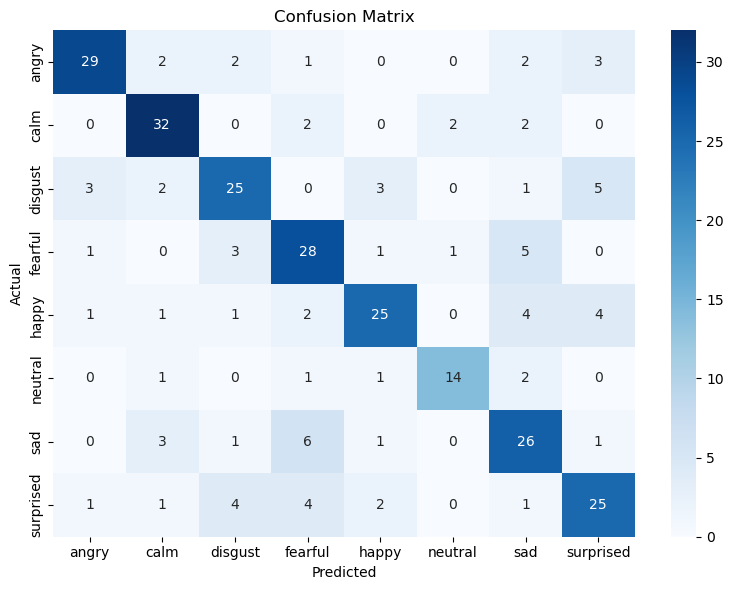

In [14]:
#Evaluation of model
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_test_label=y_test.values.argmax(axis=1)
y_pred_label=y_pred
accuracy=accuracy_score(y_test_label,y_pred_label)
print("Accuracy:",accuracy)

print("\n📊 Classification Report:")
print(classification_report(y_test_label, y_pred_label, target_names=y_test.columns))


cm = confusion_matrix(y_test_label, y_pred_label)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=y_test.columns, yticklabels=y_test.columns)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [15]:
import joblib

# Save the trained model
joblib.dump(mlp, "emotion_model.pkl")

# Save the StandardScaler used for transforming input
joblib.dump(scaler, "emotion_scaler.pkl")

print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [16]:
joblib.dump(selector, "emotion_selector.pkl")

['emotion_selector.pkl']